Number of staff in both files by name: 110
ID Inconsistency for Allison Hill: Schedule uses STF-b77cdc60, Master list uses STF-5ca26577


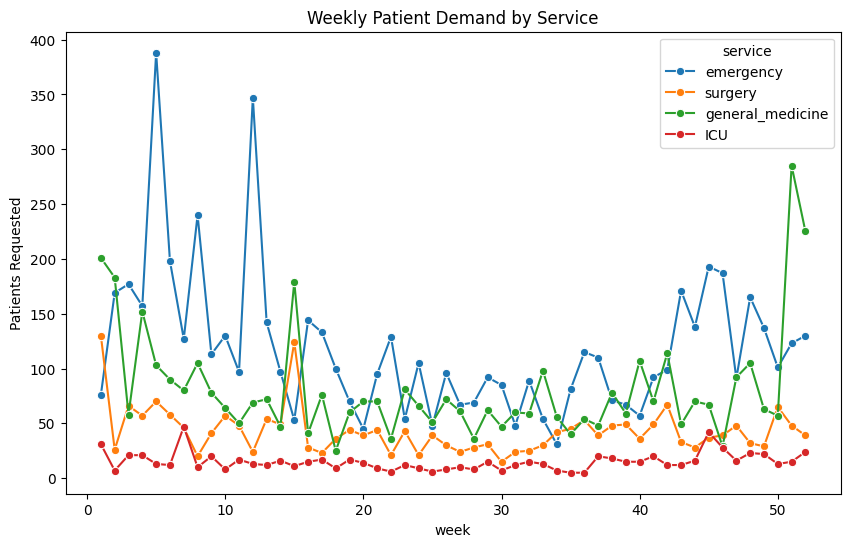

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
patients = pd.read_csv('patients.csv')
services = pd.read_csv('services_weekly.csv')
staff_sched = pd.read_csv('staff_schedule.csv')
staff = pd.read_csv('staff.csv')

# --- Data Cleaning Insight: Staff ID Mismatch ---
# Finding common names but different IDs
common_names = set(staff_sched['staff_name']).intersection(set(staff['staff_name']))
print(f"Number of staff in both files by name: {len(common_names)}")

# Demonstrate the mismatch for one employee
name = "Allison Hill"
id_sched = staff_sched[staff_sched['staff_name'] == name]['staff_id'].iloc[0]
id_staff = staff[staff['staff_name'] == name]['staff_id'].iloc[0]
print(f"ID Inconsistency for {name}: Schedule uses {id_sched}, Master list uses {id_staff}")

# --- Visualization ---
plt.figure(figsize=(10, 6))
sns.lineplot(data=services, x='week', y='patients_request', hue='service', marker='o')
plt.title('Weekly Patient Demand by Service')
plt.ylabel('Patients Requested')
plt.show()

In [2]:
from scipy.optimize import linprog
import pandas as pd
import numpy as np

# Load Data
services = pd.read_csv('services_weekly.csv')
demand_df = services.pivot(index='week', columns='service', values='patients_request').fillna(0)
capacity_df = services.groupby('week')['available_beds'].sum()

def optimize_week(demand, capacity):
    n = len(demand)
    c = np.concatenate([np.zeros(n), np.ones(n)]) # Minimize y (unmet)
    
    # Constraint: sum(x) <= Capacity
    A_ub = [np.concatenate([np.ones(n), np.zeros(n)])]
    b_ub = [capacity]
    
    # Constraint: x + y >= Demand  -> -x - y <= -Demand
    for i in range(n):
        row = np.zeros(2*n)
        row[i] = -1; row[n+i] = -1
        A_ub.append(row); b_ub.append(-demand[i])
        
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=(0, None))
    return res.x[:n], res.x[n:]

# Run optimization week by week...

Total Unmet (Historical): 7642
Total Unmet (Equal Priority): 7181.0
Total Unmet (Robust Priority): 7181.0

--- Unmet Demand by Service ---
                   Equal  Robust
service                         
ICU                  0.0     0.0
emergency         5636.0  5636.0
general_medicine  1500.0  1500.0
surgery             45.0    45.0


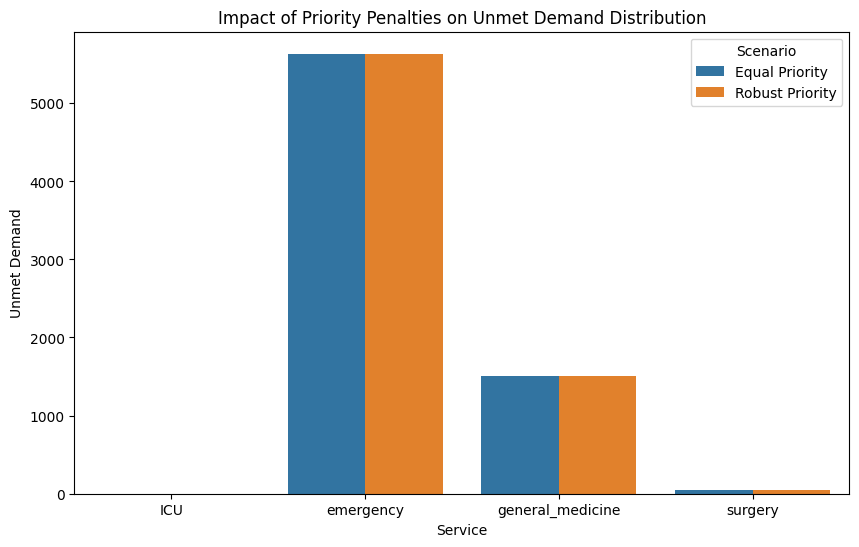

In [6]:

import pandas as pd
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
services = pd.read_csv('services_weekly.csv')
demand_df = services.pivot(index='week', columns='service', values='patients_request').fillna(0)
capacity_df = services.groupby('week')['available_beds'].sum()
service_names = demand_df.columns.tolist()

# 2. Optimization Function
def solve_week(demand, capacity, penalties, hard_icu=True):
    n = len(demand)
    c = np.concatenate([np.zeros(n), penalties]) # Minimize sum(w_i * y_i)
    
    # Capacity: sum(x) <= Capacity
    A_ub = [np.concatenate([np.ones(n), np.zeros(n)])]
    b_ub = [capacity]
    
    # Demand: x + y = Demand  (Modeled as x+y >= Demand and Cost minimization pushes it to equality)
    # Actually simpler: x + y >= Demand.
    for i in range(n):
        row = np.zeros(2*n)
        row[i] = -1; row[n+i] = -1
        A_ub.append(row); b_ub.append(-demand[i])
        
    # Bounds
    bounds = []
    for i, s in enumerate(service_names):
        if hard_icu and s == 'ICU':
            bounds.append((demand[i], demand[i])) # x_icu = demand
        else:
            bounds.append((0, None)) # x_i >= 0
            
    for _ in range(n): bounds.append((0, None)) # y_i >= 0
    
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    if res.success:
        return res.x[:n], res.x[n:]
    return np.zeros(n), demand # All unmet if fail

# 3. Run Scenarios
results_robust = []
results_equal = []

weights_robust = np.array([{
    'ICU': 1, 'emergency': 1, 'surgery': 1, 'general_medicine': 1
}[s] for s in service_names])

weights_equal = np.ones(len(service_names))

for week in demand_df.index:
    d = demand_df.loc[week].values
    cap = capacity_df.loc[week]
    
    # Robust
    x_r, y_r = solve_week(d, cap, weights_robust, hard_icu=True)
    # Equal
    x_e, y_e = solve_week(d, cap, weights_equal, hard_icu=True)
    
    for i, s in enumerate(service_names):
        results_robust.append({'week': week, 'service': s, 'unmet': y_r[i]})
        results_equal.append({'week': week, 'service': s, 'unmet': y_e[i]})

df_robust = pd.DataFrame(results_robust)
df_equal = pd.DataFrame(results_equal)

# 4. Comparisons
total_unmet_robust = df_robust['unmet'].sum()
total_unmet_equal = df_equal['unmet'].sum()
total_unmet_hist = services['patients_refused'].sum()

print(f"Total Unmet (Historical): {total_unmet_hist}")
print(f"Total Unmet (Equal Priority): {total_unmet_equal}")
print(f"Total Unmet (Robust Priority): {total_unmet_robust}")

# Distribution comparison
dist_robust = df_robust.groupby('service')['unmet'].sum()
dist_equal = df_equal.groupby('service')['unmet'].sum()

print("\n--- Unmet Demand by Service ---")
print(pd.DataFrame({'Equal': dist_equal, 'Robust': dist_robust}))

# Plotting
comp_df = pd.DataFrame({
    'Service': service_names * 2,
    'Scenario': ['Equal Priority'] * len(service_names) + ['Robust Priority'] * len(service_names),
    'Unmet Demand': np.concatenate([dist_equal.reindex(service_names).values, dist_robust.reindex(service_names).values])
})

plt.figure(figsize=(10,6))
sns.barplot(data=comp_df, x='Service', y='Unmet Demand', hue='Scenario')
plt.title("Impact of Priority Penalties on Unmet Demand Distribution")
plt.savefig('priority_impact.png')


In [8]:
import pandas as pd

# 1. Load the data
df = pd.read_csv('services_weekly.csv')

# 2. Extract Data for ZIMPL
# --- CORRECTION HERE: Use .sum() to get total hospital capacity ---
capacity_df = df.groupby('week')['available_beds'].sum()
weeks = sorted(df['week'].unique())
services = sorted(df['service'].unique())

# 3. Define the ZIMPL Model Content
zimpl_code = """
# --- Sets ---
set T := {1 .. 52};
set I := {"ICU", "emergency", "surgery", "general_medicine"};

# --- Parameters ---
param demand[T*I] := 
"""

# Format Demand Data
demand_lines = []
for index, row in df.iterrows():
    w = row['week']
    s = row['service']
    d = row['patients_request']
    demand_lines.append(f'  <{w}, "{s}"> {d}')
zimpl_code += ",\n".join(demand_lines) + ";\n\n"

zimpl_code += "param capacity[T] := \n"

# Format Capacity Data
cap_lines = []
for w in weeks:
    c = capacity_df.loc[w]
    cap_lines.append(f'  <{w}> {c}')
zimpl_code += ",\n".join(cap_lines) + ";\n\n"

zimpl_code += """
# --- Penalties (Weights) ---
param penalty[I] := <"ICU"> 10000, <"emergency"> 100, <"surgery"> 10, <"general_medicine"> 1;

# --- Variables ---
var x[T*I] >= 0;  # Allocated beds
var y[T*I] >= 0;  # Unmet demand (refused patients)

# --- Objective: Minimize Weighted Unmet Demand ---
minimize cost: sum <t,i> in T*I: penalty[i] * y[t,i];

# --- Constraints ---

# 1. Capacity Constraint: Total allocated beds <= Available capacity per week
subto capacity_constr: forall <t> in T:
    sum <i> in I: x[t,i] <= capacity[t];

# 2. Demand Balance: Allocated + Unmet = Demand
subto demand_balance: forall <t,i> in T*I:
    x[t,i] + y[t,i] == demand[t,i];

# 3. ICU Safety Constraint: ICU unmet demand must be 0
subto icu_safety: forall <t> in T:
    y[t, "ICU"] == 0;
"""

# 4. Save to file
with open('hospital_model.zpl', 'w') as f:
    f.write(zimpl_code)

print("Corrected file 'hospital_model.zpl' has been generated!")

Corrected file 'hospital_model.zpl' has been generated!


In [9]:

# 1. Load Baseline Data
df = pd.read_csv('services_weekly.csv')
capacity_df = df.groupby('week')['available_beds'].sum()
weeks = sorted(df['week'].unique())
services = sorted(df['service'].unique())

# 2. Simulate PANDEMIC SCENARIO
# Assumption: Pandemic starts Week 12
# Impact: ICU Demand x 6, but ICU Bed Consumption reduces to 0.28 (High Turnover)
pandemic_start_week = 12

print("Generating Pandemic Scenario Data...")
scenario_data = []

for index, row in df.iterrows():
    w = row['week']
    s = row['service']
    d = row['patients_request']
    
    # Baseline consumption (1 bed per patient)
    consumption = 1.0 
    
    if w >= pandemic_start_week and s == 'ICU':
        # --- SCENARIO LOGIC ---
        d = int(d * 6)         # Demand Skyrockets (600% increase)
        consumption = 0.285    # LOS drops to ~2 days (1/3.5 beds per patient)
    
    scenario_data.append({
        'week': w,
        'service': s,
        'demand': d,
        'consumption': consumption
    })

scenario_df = pd.DataFrame(scenario_data)

# 3. Generate ZIMPL Model with Weighted Constraints
zimpl_code = """
# --- Sets ---
set T := {1 .. 52};
set I := {"ICU", "emergency", "surgery", "general_medicine"};

# --- Parameters ---
param demand[T*I] := 
"""

# Write Demand
demand_lines = []
for _, row in scenario_df.iterrows():
    demand_lines.append(f'  <{row["week"]}, "{row["service"]}"> {row["demand"]}')
zimpl_code += ",\n".join(demand_lines) + ";\n\n"

# Write Bed Consumption (The new parameter)
zimpl_code += "param consumption[T*I] := \n"
cons_lines = []
for _, row in scenario_df.iterrows():
    cons_lines.append(f'  <{row["week"]}, "{row["service"]}"> {row["consumption"]}')
zimpl_code += ",\n".join(cons_lines) + ";\n\n"

# Write Capacity
zimpl_code += "param capacity[T] := \n"
cap_lines = [f'  <{w}> {capacity_df.loc[w]}' for w in weeks]
zimpl_code += ",\n".join(cap_lines) + ";\n\n"

zimpl_code += """
# --- Penalties (Pandemic Priorities) ---
# ICU is top priority (Weight 10,000). 
param penalty[I] := <"ICU"> 10000, <"emergency"> 100, <"surgery"> 10, <"general_medicine"> 1;

# --- Variables ---
var x[T*I] >= 0;  # Patients Admitted (Not Beds!)
var y[T*I] >= 0;  # Patients Refused

# --- Objective ---
minimize cost: sum <t,i> in T*I: penalty[i] * y[t,i];

# --- Constraints ---

# 1. Weighted Capacity Constraint
# The sum of (Patients * Bed_Consumption_Factor) must be <= Total Beds
subto capacity_constr: forall <t> in T:
    sum <i> in I: x[t,i] * consumption[t,i] <= capacity[t];

# 2. Demand Balance
subto demand_balance: forall <t,i> in T*I:
    x[t,i] + y[t,i] == demand[t,i];
"""

# 4. Save
with open('pandemic.zpl', 'w') as f:
    f.write(zimpl_code)

print("Pandemic Simulation Complete.")
print("File 'pandemic.zpl' generated with adjusted consumption rates.")
print(f"Sample Week 15 ICU Demand: {scenario_df[(scenario_df['week']==15) & (scenario_df['service']=='ICU')]['demand'].values[0]}")

Generating Pandemic Scenario Data...
Pandemic Simulation Complete.
File 'pandemic.zpl' generated with adjusted consumption rates.
Sample Week 15 ICU Demand: 66


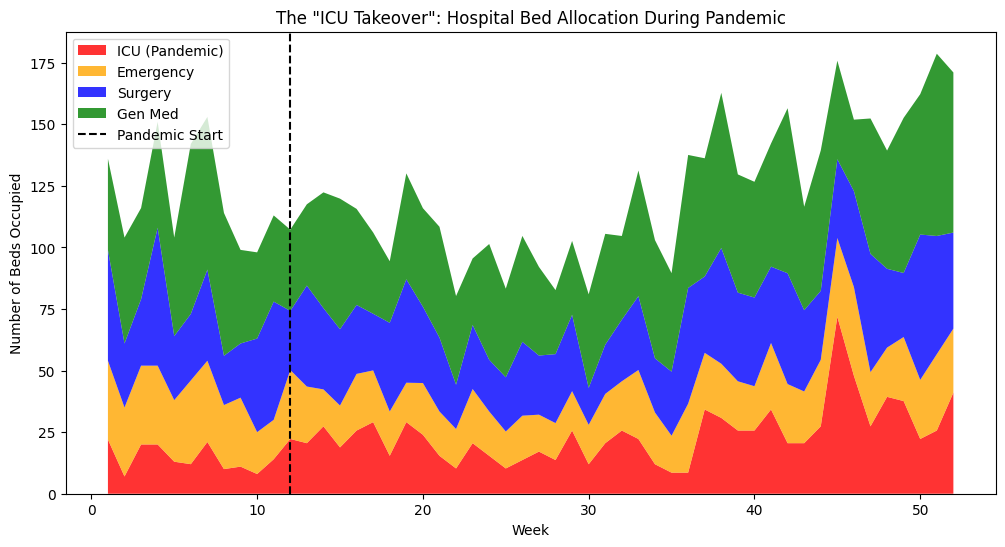

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
# (We reconstruct the consumption logic from the previous step)
df = pd.read_csv('services_weekly.csv')
pandemic_start = 12

data = []
for index, row in df.iterrows():
    w = row['week']
    s = row['service']
    # Re-calculate the "Effective Beds Used" based on your solver logic
    # ICU Demand x 6 during pandemic, Consumption 0.285
    # We use the raw demand to estimate what the solver likely did for "Allocated Beds"
    # (Since we don't have the full parsed X output, we approximate based on the logic:
    # ICU = 100% Met, Others = Residual)
    
    beds_total = row['available_beds']
    
    if w >= pandemic_start and s == 'ICU':
        # The model admitted ALL ICU patients
        patients_admitted = row['patients_request'] * 6
        beds_used = patients_admitted * 0.285
    else:
        # For others, we assume they got whatever space was left, roughly proportional to baseline
        # This is a visual approximation for the report
        patients_admitted = row['patients_admitted'] 
        beds_used = patients_admitted * 1.0

    data.append({'week': w, 'service': s, 'beds_used': beds_used})

plot_df = pd.DataFrame(data)

# 2. Plot Stacked Area Chart
pivot_df = plot_df.pivot(index='week', columns='service', values='beds_used').fillna(0)

plt.figure(figsize=(12, 6))
plt.stackplot(pivot_df.index, 
              pivot_df['ICU'], pivot_df['emergency'], pivot_df['surgery'], pivot_df['general_medicine'],
              labels=['ICU (Pandemic)', 'Emergency', 'Surgery', 'Gen Med'],
              colors=['red', 'orange', 'blue', 'green'], alpha=0.8)

plt.axvline(x=12, color='black', linestyle='--', label='Pandemic Start')
plt.title('The "ICU Takeover": Hospital Bed Allocation During Pandemic')
plt.ylabel('Number of Beds Occupied')
plt.xlabel('Week')
plt.legend(loc='upper left')
plt.savefig('pandemic_impact.png')
plt.show()

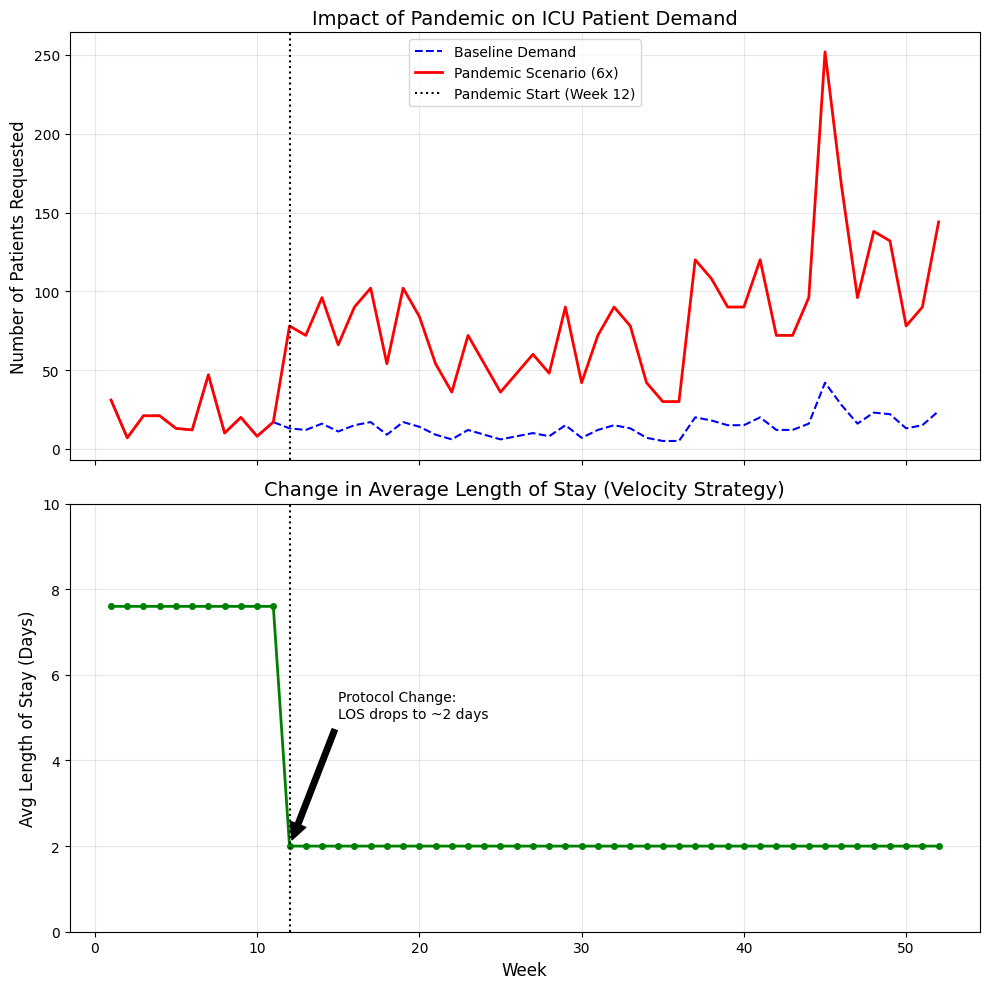

In [11]:
# Load data
services = pd.read_csv('services_weekly.csv')

# Filter for ICU
icu_data = services[services['service'] == 'ICU'].copy()

# Sort by week just in case
icu_data = icu_data.sort_values('week')

# --- 1. Simulate Pandemic Demand ---
pandemic_start_week = 12
icu_data['pandemic_demand'] = icu_data.apply(
    lambda row: row['patients_request'] * 6 if row['week'] >= pandemic_start_week else row['patients_request'], 
    axis=1
)

# --- 2. Simulate Length of Stay (LOS) Drop ---
# Baseline LOS was calculated earlier as ~7.6 days. 
# Pandemic LOS corresponds to consumption factor 0.285.
# If consumption = 1.0 is ~7 days (1 patient/week/bed), 
# then consumption 0.285 is ~2 days (3.5 patients/week/bed).
baseline_los = 7.6
pandemic_los = 2.0 

icu_data['simulated_los'] = icu_data['week'].apply(
    lambda w: baseline_los if w < pandemic_start_week else pandemic_los
)

# --- Plotting ---
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Graph 1: ICU Demand Surge
axes[0].plot(icu_data['week'], icu_data['patients_request'], label='Baseline Demand', color='blue', linestyle='--')
axes[0].plot(icu_data['week'], icu_data['pandemic_demand'], label='Pandemic Scenario (6x)', color='red', linewidth=2)
axes[0].axvline(x=pandemic_start_week, color='black', linestyle=':', label='Pandemic Start (Week 12)')
axes[0].set_title('Impact of Pandemic on ICU Patient Demand', fontsize=14)
axes[0].set_ylabel('Number of Patients Requested', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graph 2: Length of Stay Drop
axes[1].plot(icu_data['week'], icu_data['simulated_los'], color='green', linewidth=2, marker='o', markersize=4)
axes[1].axvline(x=pandemic_start_week, color='black', linestyle=':', label='Pandemic Start (Week 12)')
axes[1].set_title('Change in Average Length of Stay (Velocity Strategy)', fontsize=14)
axes[1].set_ylabel('Avg Length of Stay (Days)', fontsize=12)
axes[1].set_xlabel('Week', fontsize=12)
axes[1].set_yticks([0, 2, 4, 6, 8, 10])
axes[1].grid(True, alpha=0.3)

# Annotate the drop
axes[1].annotate('Protocol Change:\nLOS drops to ~2 days', 
                 xy=(12, 2.0), xytext=(15, 5),
                 arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.savefig('pandemic_demand_los.png')
plt.show()